<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 2. Full model fitting

This notebook describes fitting of a Bayesian hierarchical model of the effects of control (growth) and treatment (passage) on individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load), to data obtained using a multi-*E. coli* microarray.

Much of the code for the visualisation, analysis and data manipulation of the fitting results is found in the associated Python module `tools.py`, which should also be present in this directory.

The model fit can be downloaded directly from the [Zenodo](https://zenodo.org) repository, for use in this notebook:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.269638.svg)](https://doi.org/10.5281/zenodo.269638)

A code cell in the notebook below will attempt to make this download for you if the file does not already exist.

## Table of Contents

 1. [Experiment summary and interpretation](#summary)
 2. [Building the model](#building)
    1. [Stan model construction](#build_stan)
    2. [Define and fit the Stan model](#fit_stan)    
    3. [Extract the fit](#extract_stan)
 3. [Inspecting the fit](#inspect_fit)
    1. [Median parameter estimates](#median_estimates)
 4. [Identifying locus tags that confer an advantage under treatment](#locus_tags)
    1. [Plotting distribution of effects](#plot_effects)
    2. [Identifying candidates](#candidates)
 5. [Manuscript Figure 1](#figure_1)

## Experiment summary and interpretation <a id="summary"></a>

The experiment involves measuring changes in microarray probe intensity before and after a pool of bacteria is subjected to one of two processes:

1. a sample from the pool is grown in media to a defined OD, then subsampled. This growth/subsample process is repeated *n* times. [*control*]
2. a sample from the pool is applied to plant leaves, subsampled, and that subsample grown in media to a defined OD, then subsampled. This passage/subsample/growth/subsample process is repeated *n* times. [*treatment*]

In a single replicate, the microarray is exposed to genomic DNA extracted from the pool (i) before the experiment begins, and (ii) after the experiment concludes. Three replicates are performed.

<br /><div class="alert-success">
<b>All genes in all samples go through the *growth and subsampling* part of the experiment, and we wish to estimate the effect of *passage and subsampling* on individual genes.</b>
</div>

The pool of bacteria comprises *E. coli* DH10B as a carrier organism. The pool is heterogeneous, in that individual cells also contain BACs encoding random stretches of the *E. coli* Sakai chromosome. We therefore expect carrier organism genes to be unaffected by passage (treatment), and for any effects to be detectable only for genes that originate from *E. coli* Sakai.

<br /><div class="alert-success">
<b>We expect that genes conferring a phenotypic/selective advantage only for association with the plant should be enriched at the end of the treatment experiment, but not at the end of the control experiment. Sakai genes that are enriched in both treatment and control experiments may be generally advantageous for growth, but those giving a selective advantage on passage through the plant could be specifically adaptive in an environmental context.</b> 
</div>

<br /><div class="alert-danger">
<b>As the BACs describe contiguous regions of the *E. coli* Sakai genome, there is the possibility that linkage disequilibrium could result in some genes that do not confer an advantage by themselves apparently displaying enrichment after treatment.</b>
</div>

If the biological function conferring an advantage during passage is encoded by a suite of coregulated genes in an operon, we might expect all members of this suite to show evidence of enrichment after passage. It is likely that clusters of enrichment for operons or regulons post-passage will be seen in the results. Although we are not accounting for this clustering or association by operon directly in this model, it is a possible additional hierarchical term in future iterations of the model.

We should expect there to be a selective burden to the carriage of additional non-functional gDNA as BACs, so we might also anticipate a slightly negative effect on recovery under *control* conditions.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

from Bio import SeqIO

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Documents/Development/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.6/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model <a id="building"></a>

We assume that each array probe $i$ (array probes take a unique values of $i$ in the context of the entire experiment; that is, $i$ is unique for probe X replicate X treatment) measures hybridisation of genomic DNA (gDNA) in the sample that corresponds to a single gene $j[i]$, and that the measured intensity of probe $i$ relates directly to the corresponding amount of gDNA in the sample. There may be multiple probes relating to a single gene, so it is possible that $j[p] = j[q], p \neq q$. 

<div class="alert-success">
<b>This establishes a basis for pooling probe-level effects as samples of the gene-level effect.</b>
</div>

We define the (input) measurement of a probe before an experiment as $x_i$, and the (output) measurement of that probe after the experiment as $y_i$. We assume that the measurement of each probe is subject to random experimental/measurement error that is normally-distributed with mean zero and variance $\sigma_y^2$. The actual quantity of DNA measured after the experiment can then be represented as $\hat{y}$, and the irreducible error in this experiment as $\epsilon$ ($\epsilon_i$ serves to include the irreducible errors in measuring both $x_i$ and $y_i$; all errors are assumed to be Normal, so their linear combinations are also Normal).

$$y_i = \hat{y_i} + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma_y^2) \implies y_i \sim N(\hat{y_i}, \sigma_y^2)$$

The relationship between the input and output DNA quantities measured by a single probe can be represented as $\hat{y_i} = f(x_i)$. That is to say, that the measured input DNA quantity $x_i$ is a *predictor* of the output quantity. This relationship will be modelled as the sum of two linear effects:

$$\textrm{control effect} = \alpha + \beta x$$
$$\textrm{treatment effect} = \gamma + \delta x$$
$$\hat{y_i} = \textrm{control effect}(x_i) + \textrm{treatment effect}(x_i) = \alpha + \beta x_i + \gamma + \delta x_i$$

As these are linear effects, we have intercept/offset parameters ($\alpha$, $\gamma$) and gradient/slope parameters ($\beta$, $\delta$). 

<div class="alert-success">
<b>Where $\beta$ or $\delta$ are large, they would indicate large $x_i$-dependent effects of the control (growth) and treatment (passage) parts of the experiment respectively.</b>
</div>

As formulated above, the four parameters would be identical for all probes, but we are interested in estimating the control and treatment effects for individual genes, so we require a set of parameters for each gene (as it corresponds to probe $i$): $j[i]$. This is appropriate for the effects of growth/treatment that are specific to the levels of a single gene: $\beta$ and $\delta$.

The remaining parameters $\alpha$ and $\gamma$, the offsets from zero for each probe, could be considered to be constant across each replicate of both control and treatment experiments. They are possibly more realistically considered to be different for each array (i.e. each combination of replicate and treatment).

<div class="alert-success">
<b>The offset for any particular array can be hierarchically modelled as being drawn from a distribution representing all arrays, and we require one parameter for each of the arrays, so that for probe $i$ the corresponding array for that experiment is $k[i]$.</b>
</div>


As a result, we estimate $\alpha_{k[i]}$, $\beta_{j[i]}$, $\gamma_{k[i]}$, $\delta_{j[i]}$, and the relationship for each probe is modelled as:

$$\hat{y_i} = \textrm{control effect}_{j[i]}(x_i) + \textrm{treatment effect}_{j[i]}(x_i) = \alpha_{k[i]} + \beta_{j[i]} x_i + \gamma_{k[i]} + \delta_{j[i]} x_i$$

The parameters $\alpha_{k[i]}$, $\beta_{j[i]}$, $\gamma_{k[i]}$, $\delta_{j[i]}$ (and $\epsilon_i$) are to be estimated by the model fit. 

<br /><div class="alert-success">
<b>We assume that the values of each parameter, e.g. $\alpha_{k[i]}$, are drawn from a single *pooled distribution* for that parameter, $\alpha \sim \textrm{some distribution}$.</b>
</div>

This pooling ensures that our fits are not completely pooled as a single estimate $\alpha_{k[i]} = \alpha$, which would imply that all parameter estimates are constant for all genes/arrays, a situation that would be completely uninformative for our goal to identify gene-level effects, and which would *underfit* our model. It also means that our estimates are not completely unpooled, which would allow all parameter estimates to vary independently. That situation would be equivalent to simultaneously fitting independent linear relationships to each gene, and so risk *overfitting* our model to the measured data.


<br /><div class="alert-warning">
<b>NOTE: By using a *pooled distribution*, we allow a parameter estimate for each gene to influence the estimates of that parameter for all other genes in the experiment, constrained by an expected distribution of that parameter's values. To do this, we define a *prior distribution* for each parameter, but we do not specify its mean or variance, allowing the parameters of these *pooled distributions* also to be estimated when fitting our model.</b>
</div>

For each parameter's *prior* we choose a Cauchy distribution, because it has fat tails and infinite variance. This does not constrain outlying and extreme values (those we are interested in) so much as other distributions (e.g. Normal or Student's *t*):

$$\alpha_{k[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{k[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$

Each parameter's prior distribution requires a fit of both its mean and variance, and these also become parameters in our model. The means are free to vary, but we assume that the variance of each parameter's prior can be drawn from a Uniform distribution on the range (0, 100):

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$

<div class="alert-success">
<b>We therefore construct the following model of the experiment:</b>

$$\hat{y_i} = \alpha_{k[i]} + \beta_{j[i]} x_i + \gamma_{k[i]} t_i + \delta_{j[i]} t_i x_i$$
$$y_i \sim N(\hat{y_i}, \sigma_y^2)$$
$$\alpha_{k[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{k[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$
$$\sigma_y \sim U(0, \infty)$$

<ul>
<li> $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
<li> $\hat{y_i}$: actual probe intensity for probe $i$ (specific to each replicate)
<li> $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
<li> $t_i$: 0/1 pseudovariable indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
<li> $\alpha_{k[i]}$: control effect offset for treatment X replicate $k$ (used for probe $i$)
<li> $\mu_{\alpha}$: mean control effect offset for all arrays
<li> $\sigma_{\alpha}$: control effect offset variance for all arrays
<li> $\beta_{j[i]}$: control effect slope for gene $[j[i]$
<li> $\mu_{\beta}$: mean control effect slope for all genes
<li> $\sigma_{\beta}$: control effect slope variance for all genes
<li> $\gamma_{k[i]}$: treatment effect offset for treatment X replicate $k$ (used for probe $i$)
<li> $\mu_{\gamma}$: mean treatment effect offset for all arrays
<li> $\sigma_{\gamma}$: treatment effect offset variance for all arrays
<li> $\delta_{j[i]}$: treatment effect slope for gene $j[i]$
<li> $\mu_{\delta}$: mean treatment effect slope for all genes
<li> $\sigma_{\delta}$: treatment effect slope variance for all genes
<li> $\sigma_y$: variance in measurement due to irreducible error
</ul>
</div>

### Load input data for fit

In the cells below we load in the data to be fit, and define useful variables for inspecting/analysing the data later:

* `locus_tags`: the unique locus tags represented in the dataset
* `ntags`: the number of unique locus tags
* `arrays`: the arrays (combinations of replicate X treatment) used in the experiment
* `narrays`: the number of arrays used
* `outdir`: path to the directory in which to place model fit output
* `outfile`: path to the model fit output file (pickled dataframe)

In [2]:
# load clean, normalised, indexed data
data = pd.read_csv("datasets/normalised_array_data.tab", sep="\t")  # full dataset
#data = pd.read_csv("datasets/reduced_locus_data.tab", sep="\t")  # reduced dataset
#data = data[:100]  # uncomment this for debugging

# useful values
locus_tags = data['locus_tag'].unique()
ntags = len(locus_tags)
arrays = data['repXtrt'].unique()
narrays = len(arrays)

In [3]:
# Create output directory and filename to hold the fitted model
outdir = "model_fits"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, 'full_model_fit.pkl')

### Stan model construction <a id="build_stan"></a>

We need to define `data`, `parameters` and our `model` for [`Stan`](http://mc-stan.org/).

<div class="alert-success">
In the `data` block, we have:

<ul>
<li> `N`: `int`, the number of data points
<li> `J`: `int`, the number of unique locus tags (`J` < `N`)
<li> `K`: `int`, the number of unique treatment X replicate combinations (arrays)
<li> `array`: `int[N]`, an index list of arrays
<li> `tag`: `int[N]`, an index list of locus tags
<li> `t`: `vector[N]`, 0/1 control/treatment values for each probe
<li> `x`: `vector[N]`, the input log(intensity) values
<li> `y`: `vector[N]`, the output log(intensity) values
</ul>

In the `parameter` block, we have:

<ul>
<li> `a`: `real vector[K]`, estimated offset effect on log(intensity) of the *control* for each array
<li> `mu_a`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the *control* effect offset, for all arrays
<li> `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the *control* effect offset, for all arrays
<li> `b`: `real vector[J]`, estimated slope effect on log(intensity) of the *control* for each locus tag/gene
<li> `mu_b`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the *control* effect slope, for all locus tags
<li> `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the *control* effect slope, for all locus tags
<li> `g`: `real vector[K]`, estimate of the influence of treatment on the output measured intensity (offset) for array
<li> `mu_g`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the offset for all arrays due to *treatment*
<li> `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the offset for all arrays due to *treatment*
<li> `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope) for each locus tag/gene
<li> `mu_d`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the slope for all locus tags due to *treatment*
<li> `sigma_d`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the slope for all locus tags due to *treatment*
<li> `sigma`: `real<lower=0>`, the irreducible error in the experiment/model
</ul>

We also define a `transformed parameter`:

<ul>
<li> `y_hat[i] <- b[tag[i]] * x[i] + a[array[i]] + g[tag[i]] * t[i] + d[array[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.
</ul>
</div>

### Define and fit the Stan model <a id="fit_stan"></a>

In the cells below we define the model to be fit, in the Stan language, conduct the fit, and save the fit out to a pickled dataframe (or load it in from one, depending on which code is commented out).

In [4]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=0> K;  
  int<lower=1, upper=J> tag[N];
  int<lower=1, upper=K> array[N];  
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[K] a;
  vector[J] b;
  vector[K] g;
  vector[J] d;
  real mu_a;
  real mu_b;
  real mu_g;
  real mu_d;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_g;
  real<lower=0,upper=100> sigma_d;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[array[i]] + b[tag[i]] * x[i] + g[array[i]] * t[i] + d[tag[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ cauchy(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ cauchy(mu_b, sigma_b);

  sigma_g ~ uniform(0, 100);
  g ~ cauchy(mu_g, sigma_g);

  sigma_d ~ uniform(0, 100);
  d ~ cauchy(mu_d, sigma_d);

  y ~ normal(y_hat, sigma);
}
"""

In [5]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': ntags,
                       'K': narrays,
                       'tag': data['locus_tag_index'] + 1,
                       'array': data['repXtrt_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

<div class="alert-danger">
<b>At this point, you have two options to obtain the model fit data</b>
</div>

1. Run the model fit 'live' in the notebook. This may take several hours. **USE CELL (1)**
  1. (optionally) save the newly-generated model fit to a local file. **USE CELL (2)**
2. Load the model fit from a local file. **USE CELL (4)**
  1. If you have not generated the data locally, then you can download it from Zenodo **USE CELL (3) FIRST**.
  
It may be quicker to download the data from Zenodo using the button below, than to use cell (3), but be sure to place the downloaded file in the correct location as specified in the variable `outfile`.

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.269638.svg)](https://doi.org/10.5281/zenodo.269638)

In [6]:
# (1) USE THIS CELL TO RUN THE STAN FIT - takes a few hours on my laptop
#treatment_fit = pystan.stan(model_code=treatment_model,
#                            data=treatment_data_dict,
#                            iter=1000, chains=2,
#                            seed=tools.SEED)

In [7]:
# (2) USE THIS CELL TO SAVE THE STAN FIT TO A PICKLE FILE
#unpermutedChains = treatment_fit.extract()
#unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
#pickle.dump(unpermutedChains_df, open(outfile, 'wb'))

In [8]:
# (3) USE THIS CELL TO DOWNLOAD THE STAN FIT FROM ZENODO: DOI:10.5281/zenodo.269638
# The file will not be downloaded if it already exists locally.
# The file is 0.5GB in size, so may take some time to download
import urllib.request
if not os.path.isfile(outfile):
    zenodo_url = "https://zenodo.org/record/269638/files/full_model_fit.pkl"
    response = urllib.request.urlretrieve(zenodo_url, outfile)

In [9]:
# (4) USE THIS CELL TO LOAD THE STAN FIT FROM A PICKLE FILE
# Import the previously-fit model
treatment_fit = pickle.load(open(outfile, 'rb'))

### Extract the fit <a id="extract_stan"></a>

<br /><div class="alert-warning">
<b>In the cells below we load in the contents of the pickled output (if the fit has already been run), and then extract useful summary information about mean, median, variance, and credibility intervals for the parameter estimates.</b>
</div>

<div class="alert-success">
<ul>
<li> parameters $\alpha$, $\beta$, $\gamma$ and $\delta$ are represented by their Roman letter equivalents `a`, `b`, `g` and `d`.
<li> `*_mean` and `*_median` are the mean and median estimates for the parameter over the ensemble
<li> `*_sem` is the standard deviation for the parameter estimate over the ensemble
<li> `*_Npc` is the *N*th percentile for the parameter estimate, over the ensemble. These can be combined to obtain credibility intervals (e.g. the range `a_25pc`..`a_75pc` constitutes the 50% CI for $\alpha_{j[i]}$.
</div>

In [10]:
# Get summary data for parameter estimates
# use 'fit' for the model fit directly, and 'df'for loaded pickled data
(estimates_by_probe, estimates) = tools.extract_variable_summaries(treatment_fit, 'df',
                                                                  ['a', 'b', 'g', 'd'],
                                                                  [arrays, locus_tags, arrays, locus_tags],
                                                                  data)

In [11]:
# Inspect the data, one row per experiment probe
estimates_by_probe.head()

,probe,replicate,treatment,repXtrt,input,output,log_input,log_output,match,locus_tag,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
0,A_07_P052986,1,0,rep1trt0,13.354233,10.507812,2.591833,2.352119,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176,...,0.200417,0.262675,0.335062,-0.510635,-0.283252,-0.05752,-0.024356,-0.167816,-0.077139,0.151117
1,A_07_P045401,1,0,rep1trt0,8.442597,9.590875,2.133290,2.260812,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176,...,0.200417,0.262675,0.335062,-0.510635,-0.283252,-0.05752,-0.024356,-0.167816,-0.077139,0.151117
2,A_07_P062008,1,0,rep1trt0,5.553664,5.964808,1.714458,1.785877,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176,...,0.200417,0.262675,0.335062,-0.510635,-0.283252,-0.05752,-0.024356,-0.167816,-0.077139,0.151117
3,A_07_P052986,2,0,rep2trt0,6.815142,11.374824,1.919147,2.431403,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176,...,0.395308,0.393646,0.215424,-0.510635,-0.283252,-0.05752,-0.024356,-0.167816,-0.077139,0.151117
4,A_07_P045401,2,0,rep2trt0,5.823013,13.017137,1.761818,2.566267,lcl|NC_002695.1_cds_NP_309203.1_1134,ECs1176,...,0.395308,0.393646,0.215424,-0.510635,-0.283252,-0.05752,-0.024356,-0.167816,-0.077139,0.151117


In [12]:
# Inspect the data, one row per locus tag
estimates.head()

,locus_tag,b_2.5pc,b_25pc,b_75pc,b_97.5pc,b_mean,b_median,b_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
5515,ECDH10B_RS00010,0.907909,0.932580,0.950421,0.964608,0.941324,0.944069,0.013947,-0.106789,-0.065958,-0.048565,-0.023847,-0.058070,-0.057542,0.019050
4705,ECDH10B_RS00020,0.914396,0.934645,0.951195,0.961351,0.942357,0.944690,0.012564,-0.085109,-0.064664,-0.046774,-0.025243,-0.055638,-0.057188,0.015163
5475,ECDH10B_RS00060,0.914911,0.935482,0.951967,0.968178,0.943733,0.945555,0.013453,-0.105381,-0.067194,-0.045122,-0.014049,-0.057540,-0.057505,0.021189
5474,ECDH10B_RS00065,0.912512,0.935084,0.951980,0.965746,0.943209,0.945886,0.013542,-0.092378,-0.063993,-0.044987,-0.020414,-0.055270,-0.056006,0.017903
5469,ECDH10B_RS00070,0.901806,0.934273,0.951271,0.963839,0.941399,0.944425,0.015426,-0.098637,-0.066353,-0.045173,-0.022492,-0.057138,-0.057634,0.018181


In [13]:
# Separate estimates for Sakai and DH10B into two different dataframes
sakai_estimates = tools.split_estimates(estimates, 'sakai')
dh10b_estimates = tools.split_estimates(estimates, 'dh10b')

## Inspecting the fit <a id="inspect_fit"></a>

In the cells below, we visualise the fitted estimates for each of the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ as:

* box plots of median estimates for each locus tag
* relationship between control and treatment effects in Sakai
* plots of 50% credibility interval range and median estimate for each locus tag to identify locus tags with a possible selective advantage

### Median parameter estimates <a id="median_estimates"></a>

We first inspect the range of fitted estimates to get an overview of the relationships for the data as a whole, and then examine whether this relationship varies by *E. coli* isolate.

Making boxplots for the full set of fitted parameter estimates, for both isolates:

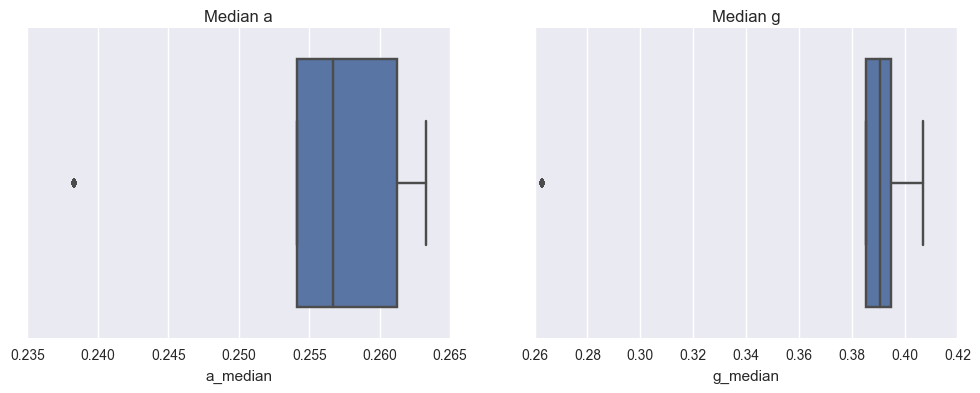

In [14]:
# Visualise median values for parameter estimates of alpha and gamma
tools.boxplot_medians(estimates_by_probe, ['a', 'g'])

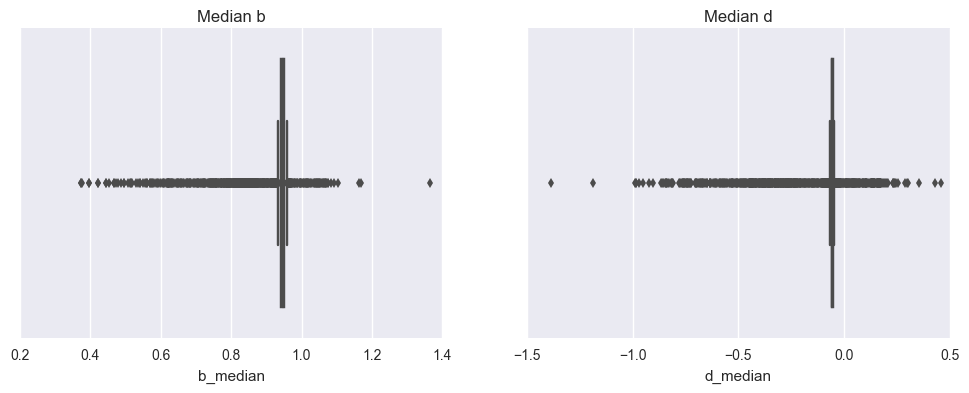

In [15]:
# Visualise median values for parameter estimates of beta and delta
tools.boxplot_medians(estimates, ['b', 'd'])

<div class="alert-success">
For this fit we can see that the estimates are all, in the main, tightly-distributed. Most estimated (median) values of $\alpha$ (control intercept), $\gamma$ (treatment intercept), and $\delta$ (treatment slope) are close to zero. Most estimated values of $\beta$ are close to (but slightly less than) unity. 

<b>This implies that:</b>

<ul>
<li> <b>The linear relationship between input and output intensity due to the control effects (growth only) is, for most genes in the experiment, a slight reduction of output intensity with respect to input intensity value, and on the whole the effect of the control/growth is neutral [median $\alpha$ ≈ 0, median $\beta$ ≈ 1]</b>
<li> <b>For most genes in the experiment there is no treatment effect due to exposure to the plant [median $\gamma$ ≈ 0, median $\delta$ ≈ 0]</b>
</ul>
</div>

<br /><div class="alert-warning">
<b>There are, however, a considerable number of outlying median values for each parameter, which suggests that a number of genes have associated parameter values that are affected by either control (growth) or treatment (passage).</b>
</div>

#### DH10B

Considering boxplots of estimated $\beta_{j[i]}$ and $\delta_{j[i]}$ for the DH10B (carrier) isolate only:

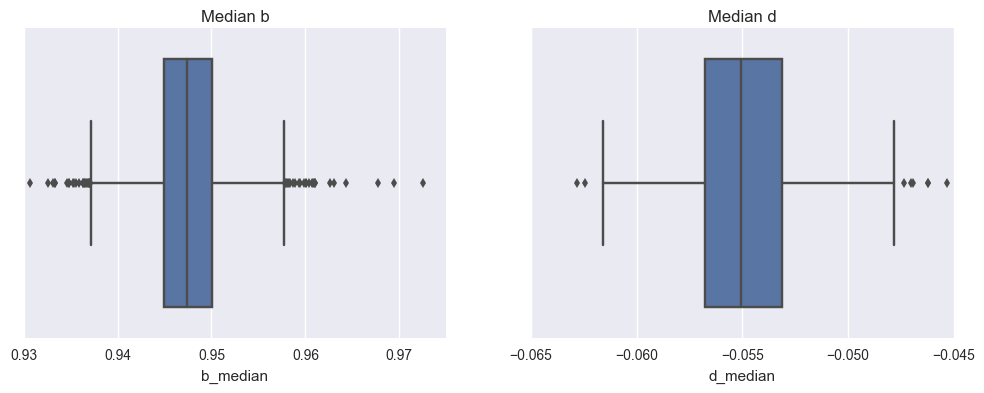

In [16]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(dh10b_estimates, ['b', 'd'])

it is clear that the median parameter estimates for DH10B are extremely restricted in their range:

* $0.93 < \beta < 0.98$
* $-0.065 < \delta < 0.045$

<div class="alert-success">
The control effect appears to be essentially *neutral*, in that the output intensity is almost a 1:1 linear relationship with the input intensity, but it is striking that the median estimates of $\gamma$ and $\delta$ are very close to zero, suggesting that passage (treatment) has almost no effect on this relationship, for any DH10B locus tag.

<b>This is exactly what would be expected for DH10B as the carrier isolate.</b>
</div>

#### Sakai

Considering the Sakai isolate parameter estimates for $\beta_{j[i]}$ and $\gamma_{j[i]}$ only:

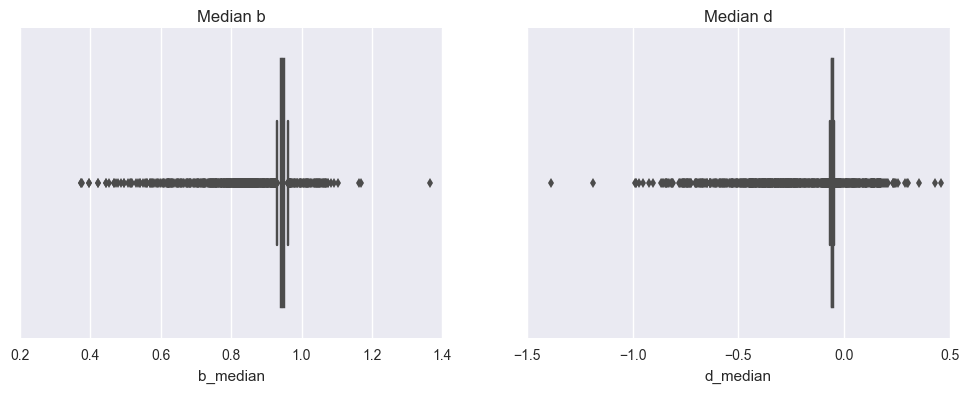

In [17]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(sakai_estimates, ['b', 'd'])

By contrast to the results for DH10B, the median parameter estimates for Sakai have many large value outliers, though the bulk of estimates are close to the values seen for DH10B:

* $0.2 < \beta < 1.4$
* $-1.5 < \delta < 0.5$

<div class="alert-success">
This indicates that we see the expected result, that strong variability of control and treatment effects are effectively confined to the Sakai BAC fragments.

<b>It is expected that some genes/operons may be relatively advantageous in either growth (control) or passage (treatment) conditions, or both.</b>
</div>

We can visualise the relationships between parameter estimates for control and treatment effects in a scatterplot of control effect ($\beta$) against treatment effect ($\delta) for each locus tag. This plot can be considered in four quadrants, which are delineated by the bulk of the data which describes orthogonal effects of locus tags on growth and treatment:

<br /><div class="alert-success">
<b>(i.e. for most locus tags, there is *either* an effect on treatment or control, but *not both*)</b>
</div>

* (upper left) positive effect on growth, negative effect for treatment: may be related to ability to use growth medium more efficiently
* (upper right) positive effect on both growth and treatment: no locus tags display this characteristic
* (lower right) positive effect on treatment, negative effect for control: may be related to ability to use/exploit the plant, that is suppressive in the medium
* (lower left) negative effect on both growth and treatment: most locus tags that display an interaction lie in this group

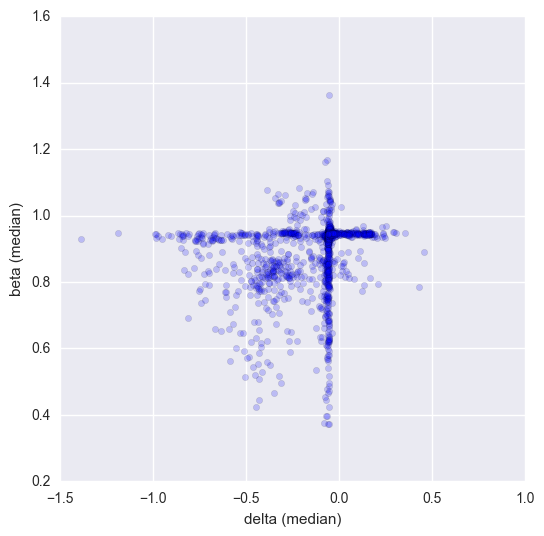

In [18]:
# Plot estimated parameters for treatment effects against control effects for Sakai
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(sakai_estimates['d_median'], sakai_estimates['b_median'], alpha=0.2)
ax.set_xlabel('delta (median)')
ax.set_ylabel('beta (median)');

<br /><div class="alert-warning">
The strong cross-like distribution indicates that most parameter estimates of $\beta$ or $\delta$ that vary from those of the bulk do so orthogonally in either *treatment* or *control* conditions, but not both. 
<br /><br />
<b>Where Sakai genes have an estimated effect under both conditions, this is typically negative for both treatment and control (lower left quadrant).</b>
</div>

## Identifying locus tags that confer an advantage under treatment and/or control <a id="locus_tags"></a>

We use a 50% credibility interval to determine whether the effect of a gene on passage is likely to be positive. Under this assumption, we identify locus tags for which the median estimate of $\delta$ is positive, and the central 50% of the parameter estimates for $\delta$ (the 50% credibility interval) does not include zero. We label these locus tags as `trt_pos` in the dataframe.

<br /><div class="alert-success">
These locus tags correspond to the genes that we should believe confer a selective advantage in passage/*treatment* (i.e. we require our estimate to be credibly positive). 
</div>

Likewise, we use a 50% credibility interval to determine whether the effect of a gene on surviving growth (control) is positive. If the 50% CI for $\beta$ does not include the 97.5 percentile for all estimates of $\beta$ (as an upper estimate of overall dataset centrality for this dataset), and the median value of $\beta$ is greater than this value, we consider that the effect of the gene on surviving growth conditions is positive. We label these locus tags as `ctl_pos` in the dataframe.

In [19]:
# Label locus tags with positive effects for control and treatment
sakai_estimates = tools.label_positive_effects(sakai_estimates)

We can count the number of locus_tags in each of the groups:

In [20]:
# Count locus tags in each of the positive groups
counts = [sum(sakai_estimates[col]) for col in ('trt_pos', 'ctl_pos', 'combined')]
print("treatment positive: {0}\ncontrol positive: {1}\nboth: {2}".format(*counts))

treatment positive: 115
control positive: 65
both: 0


which indicates, with these assumptions, that:

<div class="alert-success">
<ul>
<b>
<li> 115 genes have a credible positive effect on passage (treatment)
<li> 65 genes have a credible positive effect in the growth (control) step
<li> no genes have a credible positive effect for both growth and treatment.
</b>
</ul>
</div>

(this confirms our observation in the earlier scatterplot)

### Plotting distribution of effects on the Sakai genome <a id="plot_effects"></a>

We can show the estimated effects, and our confidence in those estimates, on a rough representation of the genome by plotting those values for each locus tag, sorted in order on the genome.

In the plots that follow, parameter estimates for each locus tag are rendered as points (the median estimate), with the 50% credibility interval for the estimate indicated as a vertical line. If the 50% CI includes a threshold value -  the median value for the bulk parameter estimate of $\beta$ or $\delta$ - then we consider that there is not strong evidence of an effect on survival due to that gene (compared to the bulk), and the interval is coloured blue.

If the interval does not include the corresponding threshold value, then it is coloured either green for a *positive* effect, or magenta for a *negative* effect.

#### Sakai

We split the Sakai estimates into groups: one for the chromosome, and one for each plasmid pOSAK and pO157, on the basis of the locus tag prefixes, annotating them with their start position on the parent molecule.

In [21]:
sakai_chromosome = sakai_estimates.loc[sakai_estimates['locus_tag'].str.startswith('ECs')]
sakai_pOSAK = sakai_estimates.loc[sakai_estimates['locus_tag'].str.startswith('pOSAK1')]
sakai_pO157 = sakai_estimates.loc[(sakai_estimates['locus_tag'].str.startswith('pO157')) |
                                  (sakai_estimates['locus_tag'].str.startswith('ECp'))]

In [22]:
# Sakai chromosome
sakai_chromosome_annotated = tools.annotate_locus_tags(sakai_chromosome,
                                                       os.path.join('..', 'data', 'Sakai',
                                                                    'GCF_000008865.1_ASM886v1_genomic.gbff'))
sakai_chromosome_annotated.sort_values('startpos', inplace=True)
#sakai_chromosome_annotated.head(15)

In [23]:
# pOSAK1
sakai_pOSAK_annotated = tools.annotate_locus_tags(sakai_pOSAK,
                                                  os.path.join('..', 'data', 'Sakai',
                                                               'GCF_000008865.1_ASM886v1_genomic.gbff'))
sakai_pOSAK_annotated.sort_values('startpos', inplace=True)
#sakai_pOSAK_annotated.head(15)

In [24]:
# pECp
sakai_pO157_annotated = tools.annotate_locus_tags(sakai_pO157,
                                                 os.path.join('..', 'data', 'Sakai',
                                                              'GCF_000008865.1_ASM886v1_genomic.gbff'))
sakai_pO157_annotated.sort_values('startpos', inplace=True)
#sakai_pO157_annotated.head(15)

In [25]:
# Regions of interest
regions = [('S-loop 71', 'ECs1276', 'ECs1288', 1.3),
           ('SpLE1', 'ECs1299', 'ECs1410', 1.5),
           ('S-loop 225', 'ECs4325', 'ECs4341', 1.5),
           ('S-loop 231', 'ECs4379', 'ECs4387', 1.3)]
annotations = {k:(tools.get_lt_index(v0, sakai_chromosome_annotated),
                  tools.get_lt_index(v1, sakai_chromosome_annotated), v2) for
               k, v0, v1, v2 in regions}

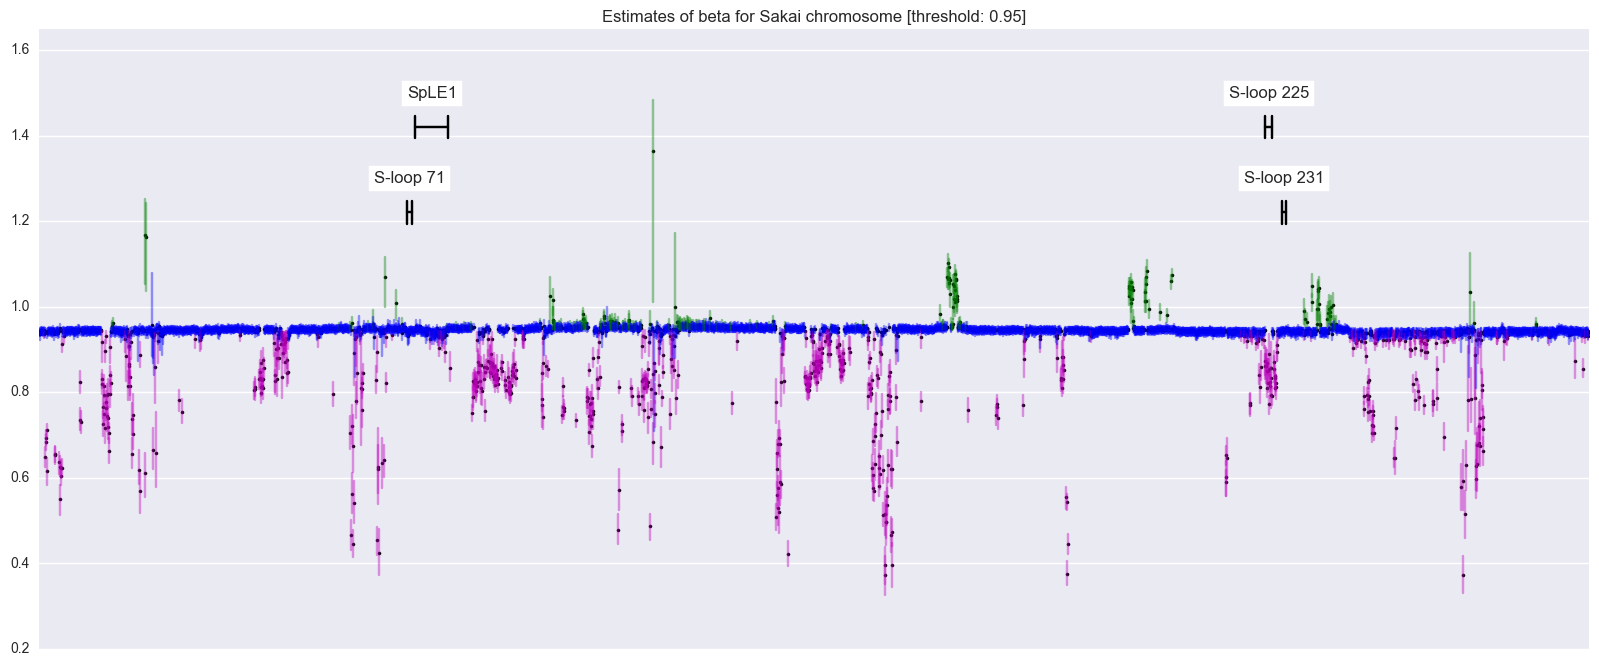

In [26]:
# Plot genome-wide estimates of beta for Sakai and mark values that don't include the median beta in 50% CI
beta_thresh = np.median(sakai_chromosome_annotated['b_median'])  

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of beta for Sakai chromosome'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

# Plot on the figure axes
tools.plot_parameter(sakai_chromosome_annotated, ax, 'b', beta_thresh, annotations=annotations);

In [27]:
# Regions of interest
regions = [('S-loop 71', 'ECs1276', 'ECs1288', 1),
           ('SpLE1', 'ECs1299', 'ECs1410', 1.8),
           ('S-loop 225', 'ECs4325', 'ECs4341', 1.8),
           ('S-loop 231', 'ECs4379', 'ECs4387', 1)]
annotations = {k:(tools.get_lt_index(v0, sakai_chromosome_annotated),
                  tools.get_lt_index(v1, sakai_chromosome_annotated), v2) for
               k, v0, v1, v2 in regions}

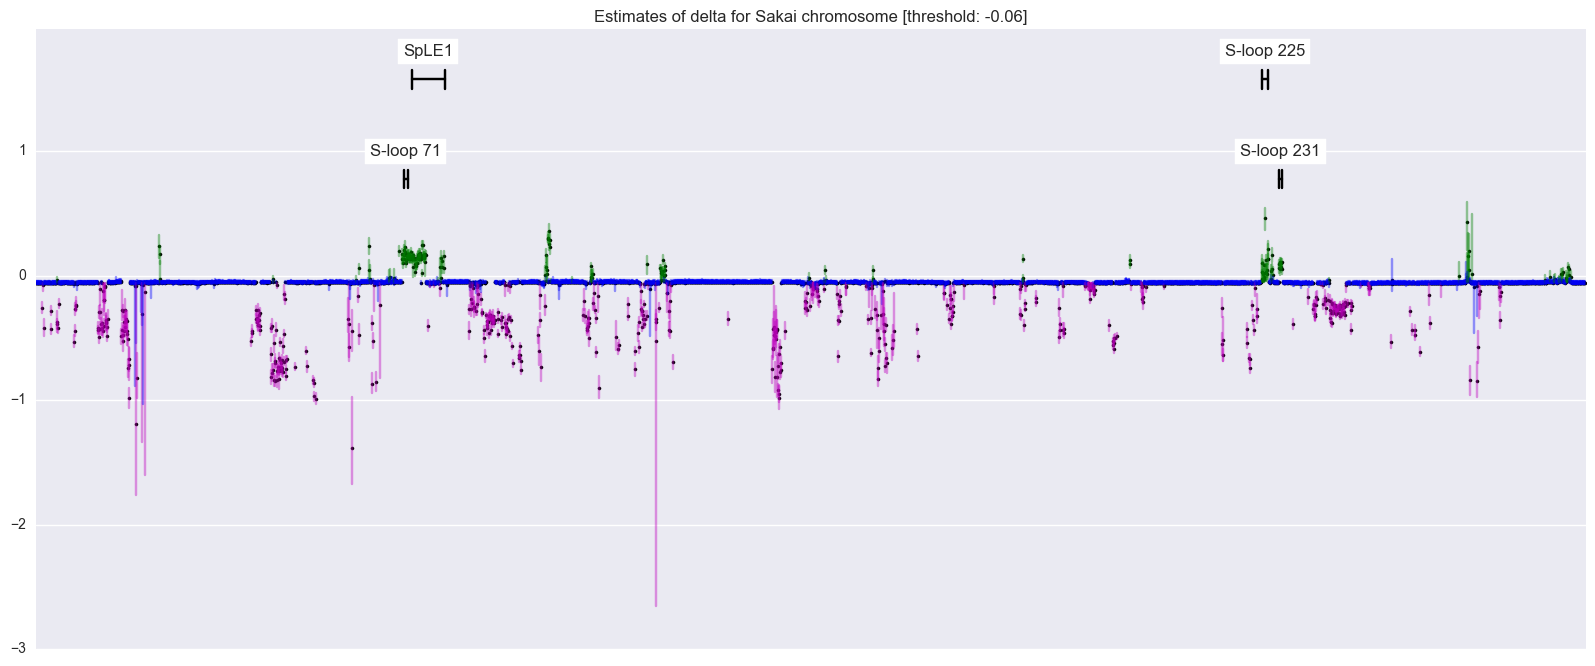

In [28]:
# Plot genome-wide estimates of delta for Sakai and mark values that don't include zero in 50%CI
delta_thresh = np.median(sakai_chromosome_annotated['d_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of delta for Sakai chromosome'
plt.title("{0} [threshold: {1:.2f}]".format(title, delta_thresh))

tools.plot_parameter(sakai_chromosome_annotated, ax, 'd', delta_thresh, annotations=annotations)

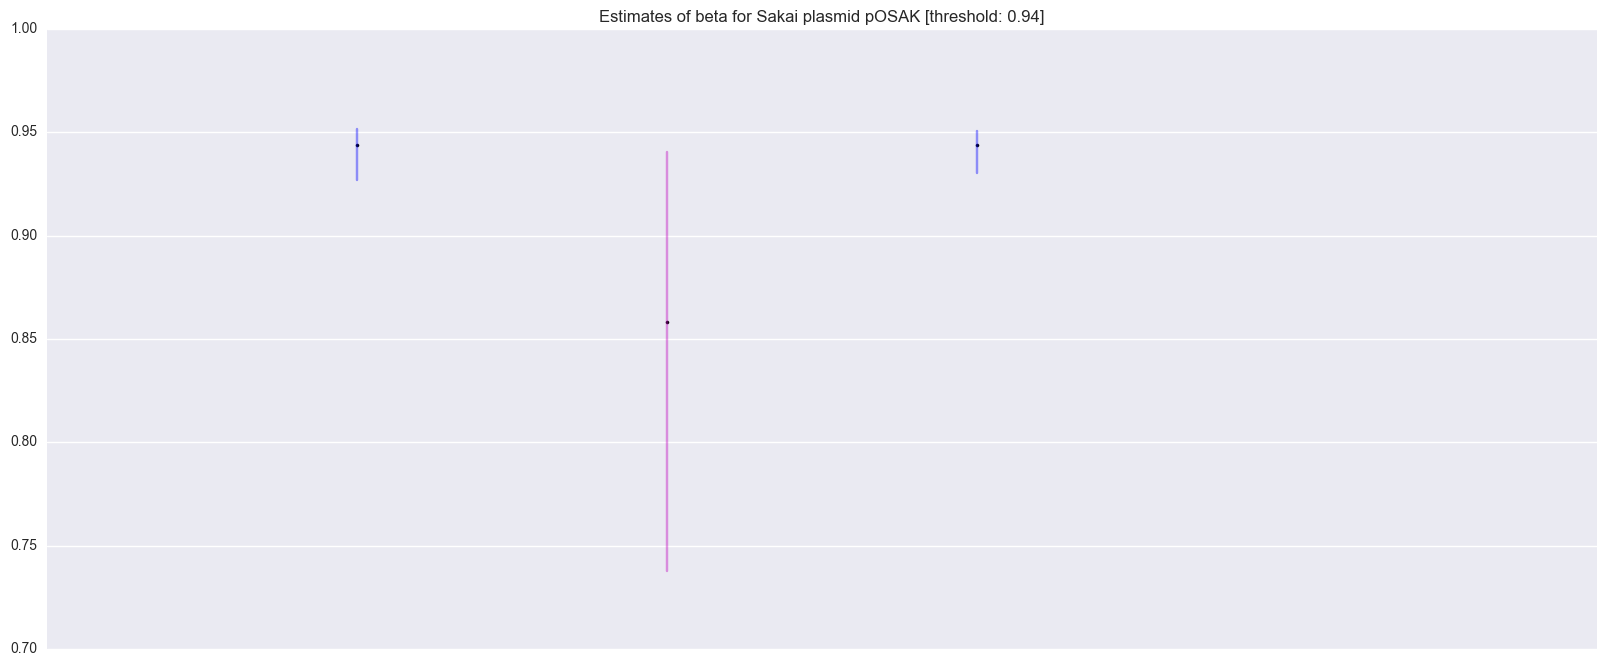

In [29]:
# Plot genome-wide estimates of beta for Sakai and mark values that don't include the median beta in 50% CI
beta_thresh = np.median(sakai_pOSAK_annotated['b_median']) 

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of beta for Sakai plasmid pOSAK'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(sakai_pOSAK_annotated, ax, 'b', beta_thresh)

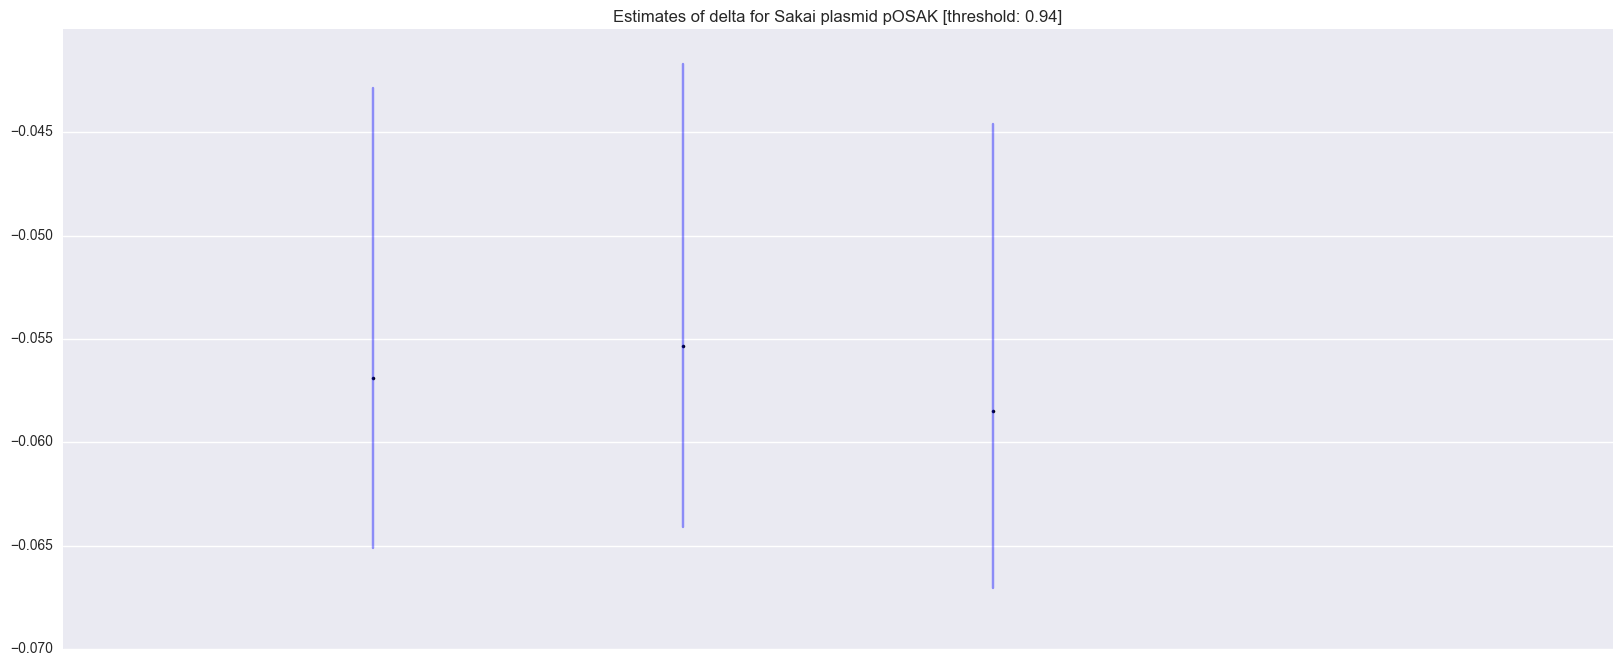

In [30]:
# Plot genome-wide estimates of delta for Sakai and mark values that don't include zero in 50% CI
delta_thresh = np.median(sakai_pOSAK_annotated['d_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of delta for Sakai plasmid pOSAK'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(sakai_pOSAK_annotated, ax, 'd', delta_thresh)

In [31]:
# Regions of interest
regions = [('StcE', 'pO157p01', 'pO157p01', 0.98),
           ('etp T2SS', 'pO157p02', 'pO157p14', 1)]
annotations = {k:(tools.get_lt_index(v0, sakai_pO157_annotated),
                  tools.get_lt_index(v1, sakai_pO157_annotated), v2) for
               k, v0, v1, v2 in regions}

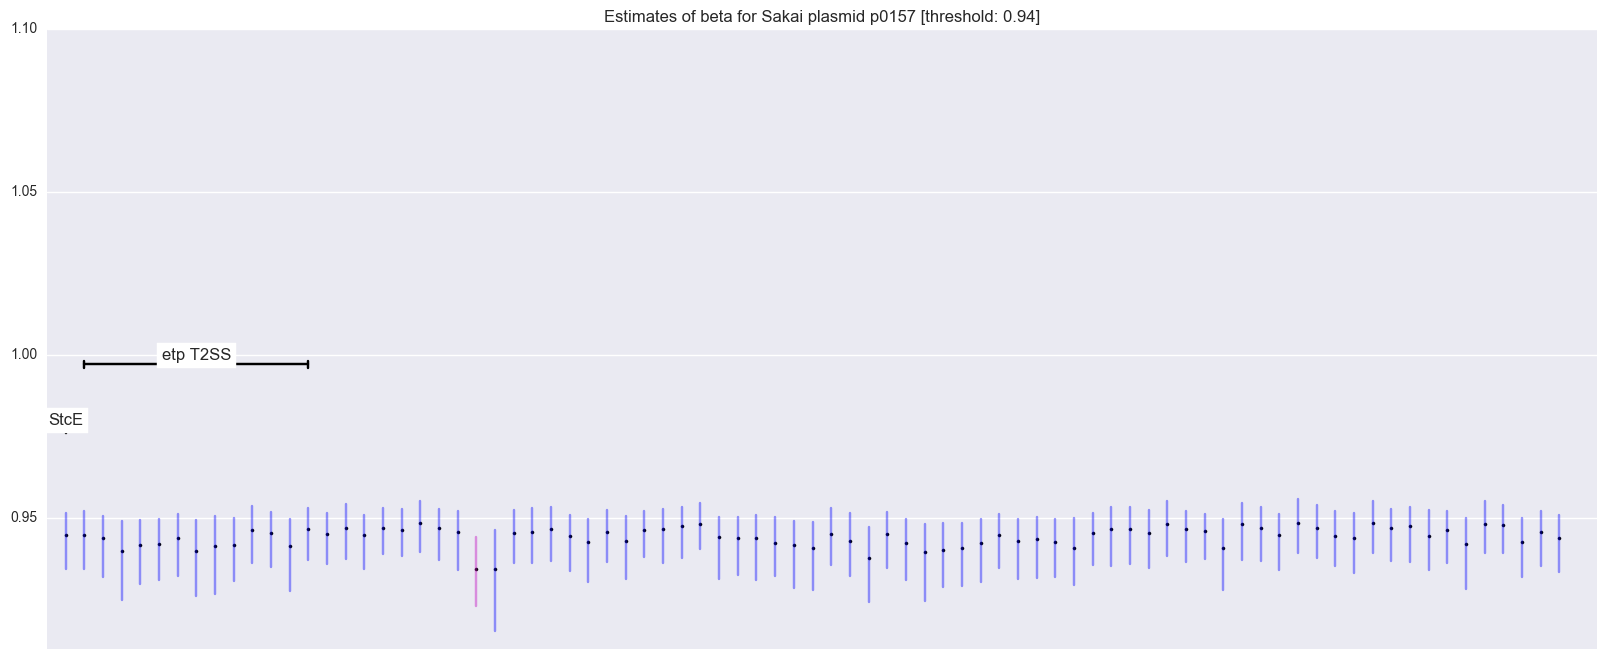

In [32]:
# Plot genome-wide estimates of beta for Sakai and mark values that don't include the median beta in 50% CI
beta_thresh = np.median(sakai_pO157_annotated['b_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of beta for Sakai plasmid p0157'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(sakai_pO157_annotated, ax, 'b', beta_thresh, annotations=annotations)

In [33]:
# Regions of interest
regions = [('StcE', 'pO157p01', 'pO157p01', 0.13),
           ('etp T2SS', 'pO157p02', 'pO157p14', 0.19)]
annotations = {k:(tools.get_lt_index(v0, sakai_pO157_annotated),
                  tools.get_lt_index(v1, sakai_pO157_annotated), v2) for
               k, v0, v1, v2 in regions}

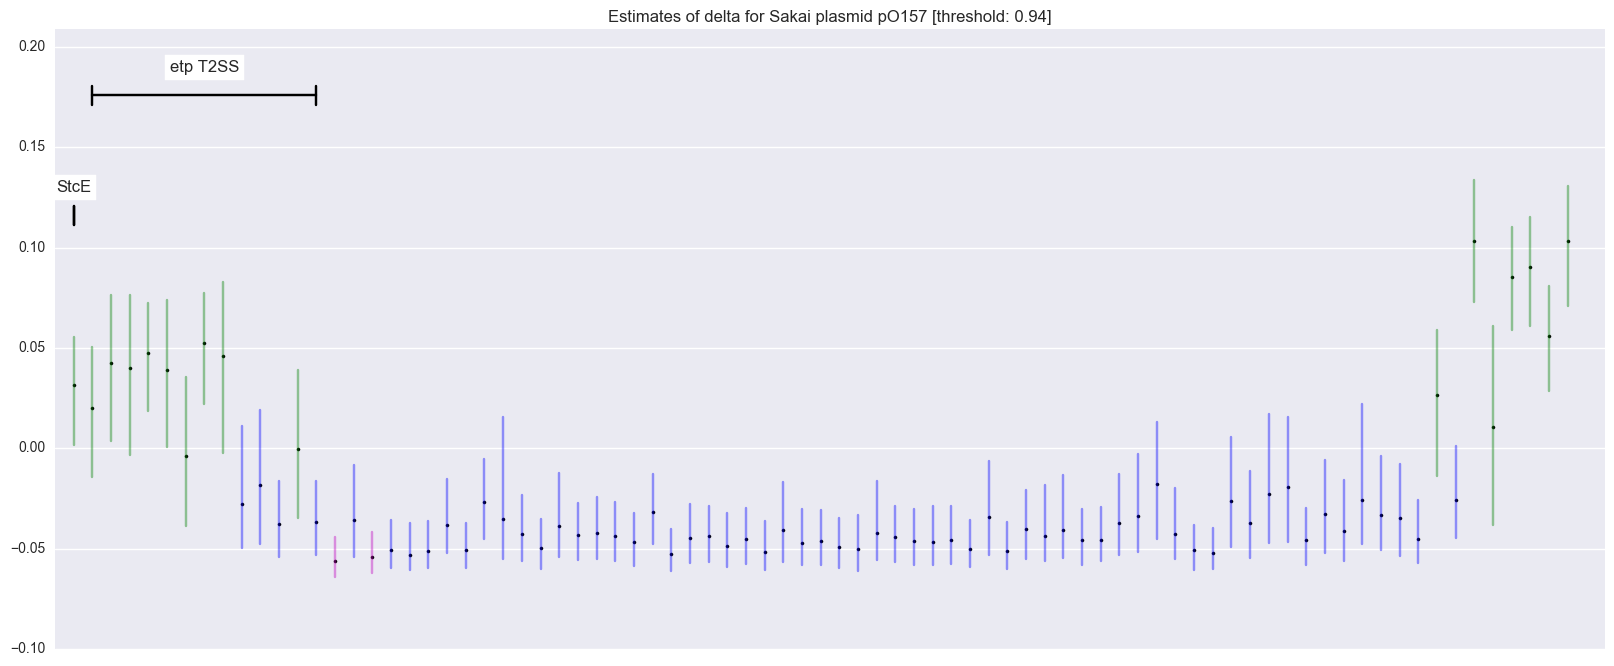

In [34]:
# Plot genome-wide estimates of delta for Sakai and mark values that don't include zero in 50% CI
delta_thresh = np.median(sakai_pO157_annotated['d_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of delta for Sakai plasmid pO157'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(sakai_pO157_annotated, ax, 'd', delta_thresh, annotations=annotations)

<div class="alert-success">
These plots indicate that most Sakai genes do not produce parameter estimates that are indicative of credible effects in the control or treatment, in either direction.
<br /><br />
Where effects are seen they tend to cluster on the genome, which is as would be expected if operons or gene clusters with common function were responsible for producing an effect. This is suggestive that we are measuring a biological effect, rather than noise.
<br /><br />
<b>In general, several clusters of both positive and negative effects appear in the chromosome and pO157 plots for effects due to control ($\beta$) and treatment ($\delta$).</b>
</div>

#### DH10B

We plot similar representations for the DH10B isolate as a control, and see that all parameter estimates for this isolate's locus tags are very similar.

<br /><div class="alert-warning">
There is a weak sinusoidal pattern of fitted estimates. As no gene ordering information is available to the model fit, and there is an apparent symmetry to this pattern, it may reflect a real underlying biological process or structure.
</div>

In [35]:
# Annotate the DH10B results
dh10b_annotated = tools.annotate_locus_tags(dh10b_estimates,
                                            os.path.join('..', 'data', 'DH10B',
                                                         'GCF_000019425.1_ASM1942v1_genomic.gbff'))
dh10b_annotated.sort_values('startpos', inplace=True)

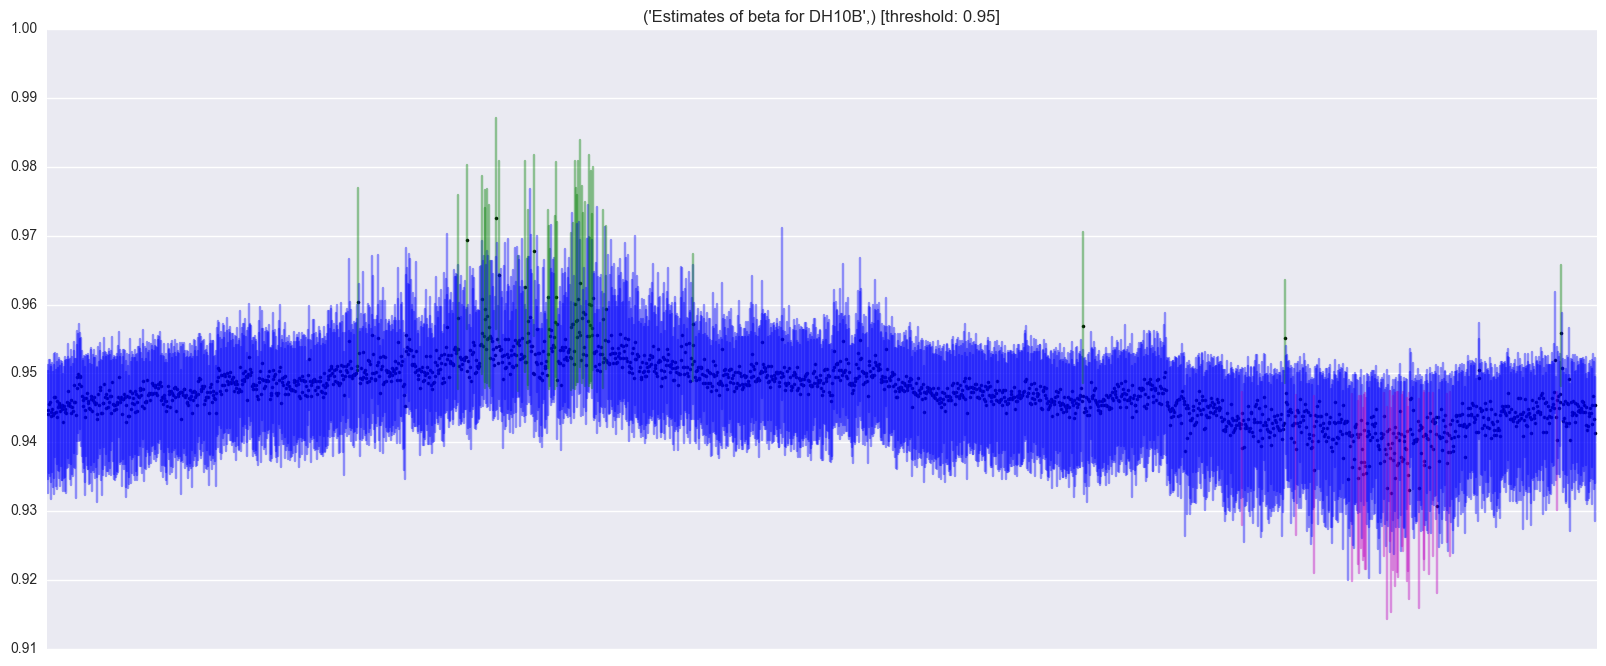

In [36]:
# Plot genome-wide estimates of beta for DH10B
beta_thresh = np.median(dh10b_estimates['b_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of beta for DH10B', 
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(dh10b_estimates, ax, 'b', beta_thresh)

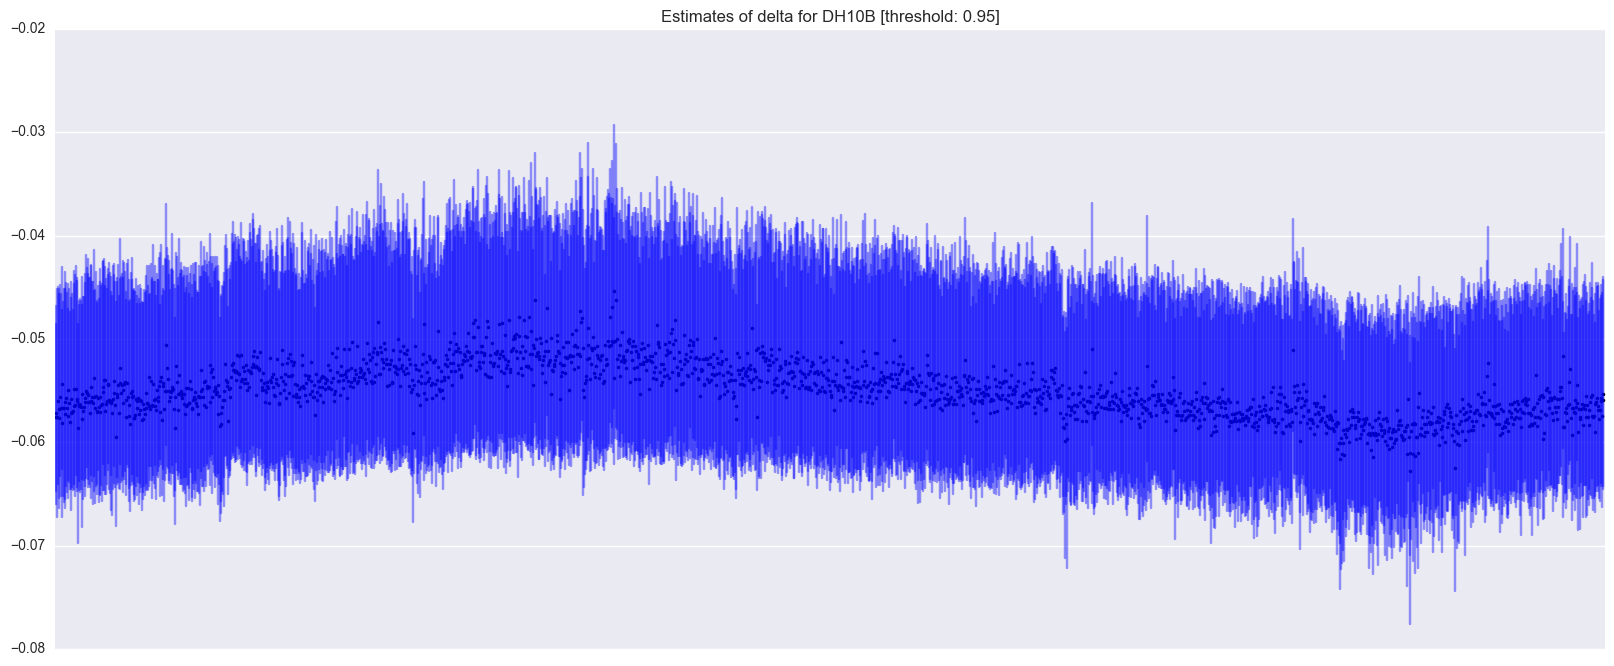

In [37]:
# Plot genome-wide estimates of delta for DH10B
delta_thresh = np.median(dh10b_estimates['d_median'])

# Create figure with title to hold the plotted axis
fig = plt.figure(figsize=(20, 8))  
ax = fig.add_subplot(1, 1, 1)
title = 'Estimates of delta for DH10B'
plt.title("{0} [threshold: {1:.2f}]".format(title, beta_thresh))

tools.plot_parameter(dh10b_estimates, ax, 'd', delta_thresh)

### Identifying Sakai candidates <a id="candidates"></a>

From the information above, we can list the 180 Sakai genes/locus tags that appear to impart a positive selective effect on treatment/passage (the green points/bars in the plots immediately above).

In [38]:
# Generate list of candidates with a positive effect under control or treatment.
candidates = sakai_estimates[sakai_estimates['ctl_pos'] | sakai_estimates['trt_pos']]
candidates = candidates[['locus_tag',
                         'b_median', 'ctl_pos',
                         'd_median', 'trt_pos']].sort_values(['ctl_pos', 'trt_pos', 'locus_tag'])
candidates.shape

(180, 5)

In [39]:
# Inspect the data
candidates.head()

,locus_tag,b_median,ctl_pos,d_median,trt_pos
3523,ECs0415,0.943381,False,0.235389,True
3522,ECs0416,0.935728,False,0.174705,True
40,ECs1121,0.948441,False,0.057269,True
3754,ECs1161,0.947319,False,0.237648,True
3005,ECs1262,0.938215,False,0.197020,True


We restrict this set to those genes that only have a credible effect on treatment/passage, identifying 115 genes with positive $\delta$ where the 50% CI does not include zero:

In [40]:
# Restrict candidates only to those with an effect on treatment/passage.
trt_only_positive = candidates.loc[candidates['trt_pos'] & ~candidates['ctl_pos']]
trt_only_positive.shape

(115, 5)

We add a column with the functional annotation of each of the candidates that appear to have a positive selective effect under treatment conditions:

In [41]:
# Annotated locus tags with functions from NCBI GenBank files
annotated = tools.annotate_locus_tags(trt_only_positive,
                                      os.path.join('..', 'data', 'Sakai',
                                                   'GCF_000008865.1_ASM886v1_genomic.gbff'))
pd.options.display.max_rows = 115 # force to show all rows
annotated

,locus_tag,b_median,ctl_pos,d_median,trt_pos,annotation,startpos
3523,ECs0415,0.943381,False,0.235389,True,periplasmic-iron-binding protein,441343
3522,ECs0416,0.935728,False,0.174705,True,regulatory protein,442371
40,ECs1121,0.948441,False,0.057269,True,host specificity protein,1203336
3754,ECs1161,0.947319,False,0.237648,True,excisionase,1247402
3005,ECs1262,0.938215,False,0.197020,True,hypothetical protein,1321781
2989,ECs1272,0.943690,False,0.130858,True,rtn-like protein,1337360
2988,ECs1273,0.945370,False,0.169504,True,FidL-like protein,1338994
2786,ECs1274,0.943394,False,0.134231,True,transcriptional regulator,1339490
2783,ECs1275,0.944433,False,0.101744,True,oxidoreductase,1340990
2777,ECs1276,0.943277,False,0.135400,True,chaperone protein,1341918


Finally, we write this data out in tab-separated format

In [42]:
# Write data to file in tab-separated format
outfile_annotated = os.path.join('datasets', 'trt_positive.tab')
annotated.to_csv(outfile_annotated, sep="\t")

<a id="figure_1"></a>
## Manuscript Figure 1

The code in the cell below will reproduce figure 1 from the manuscript.

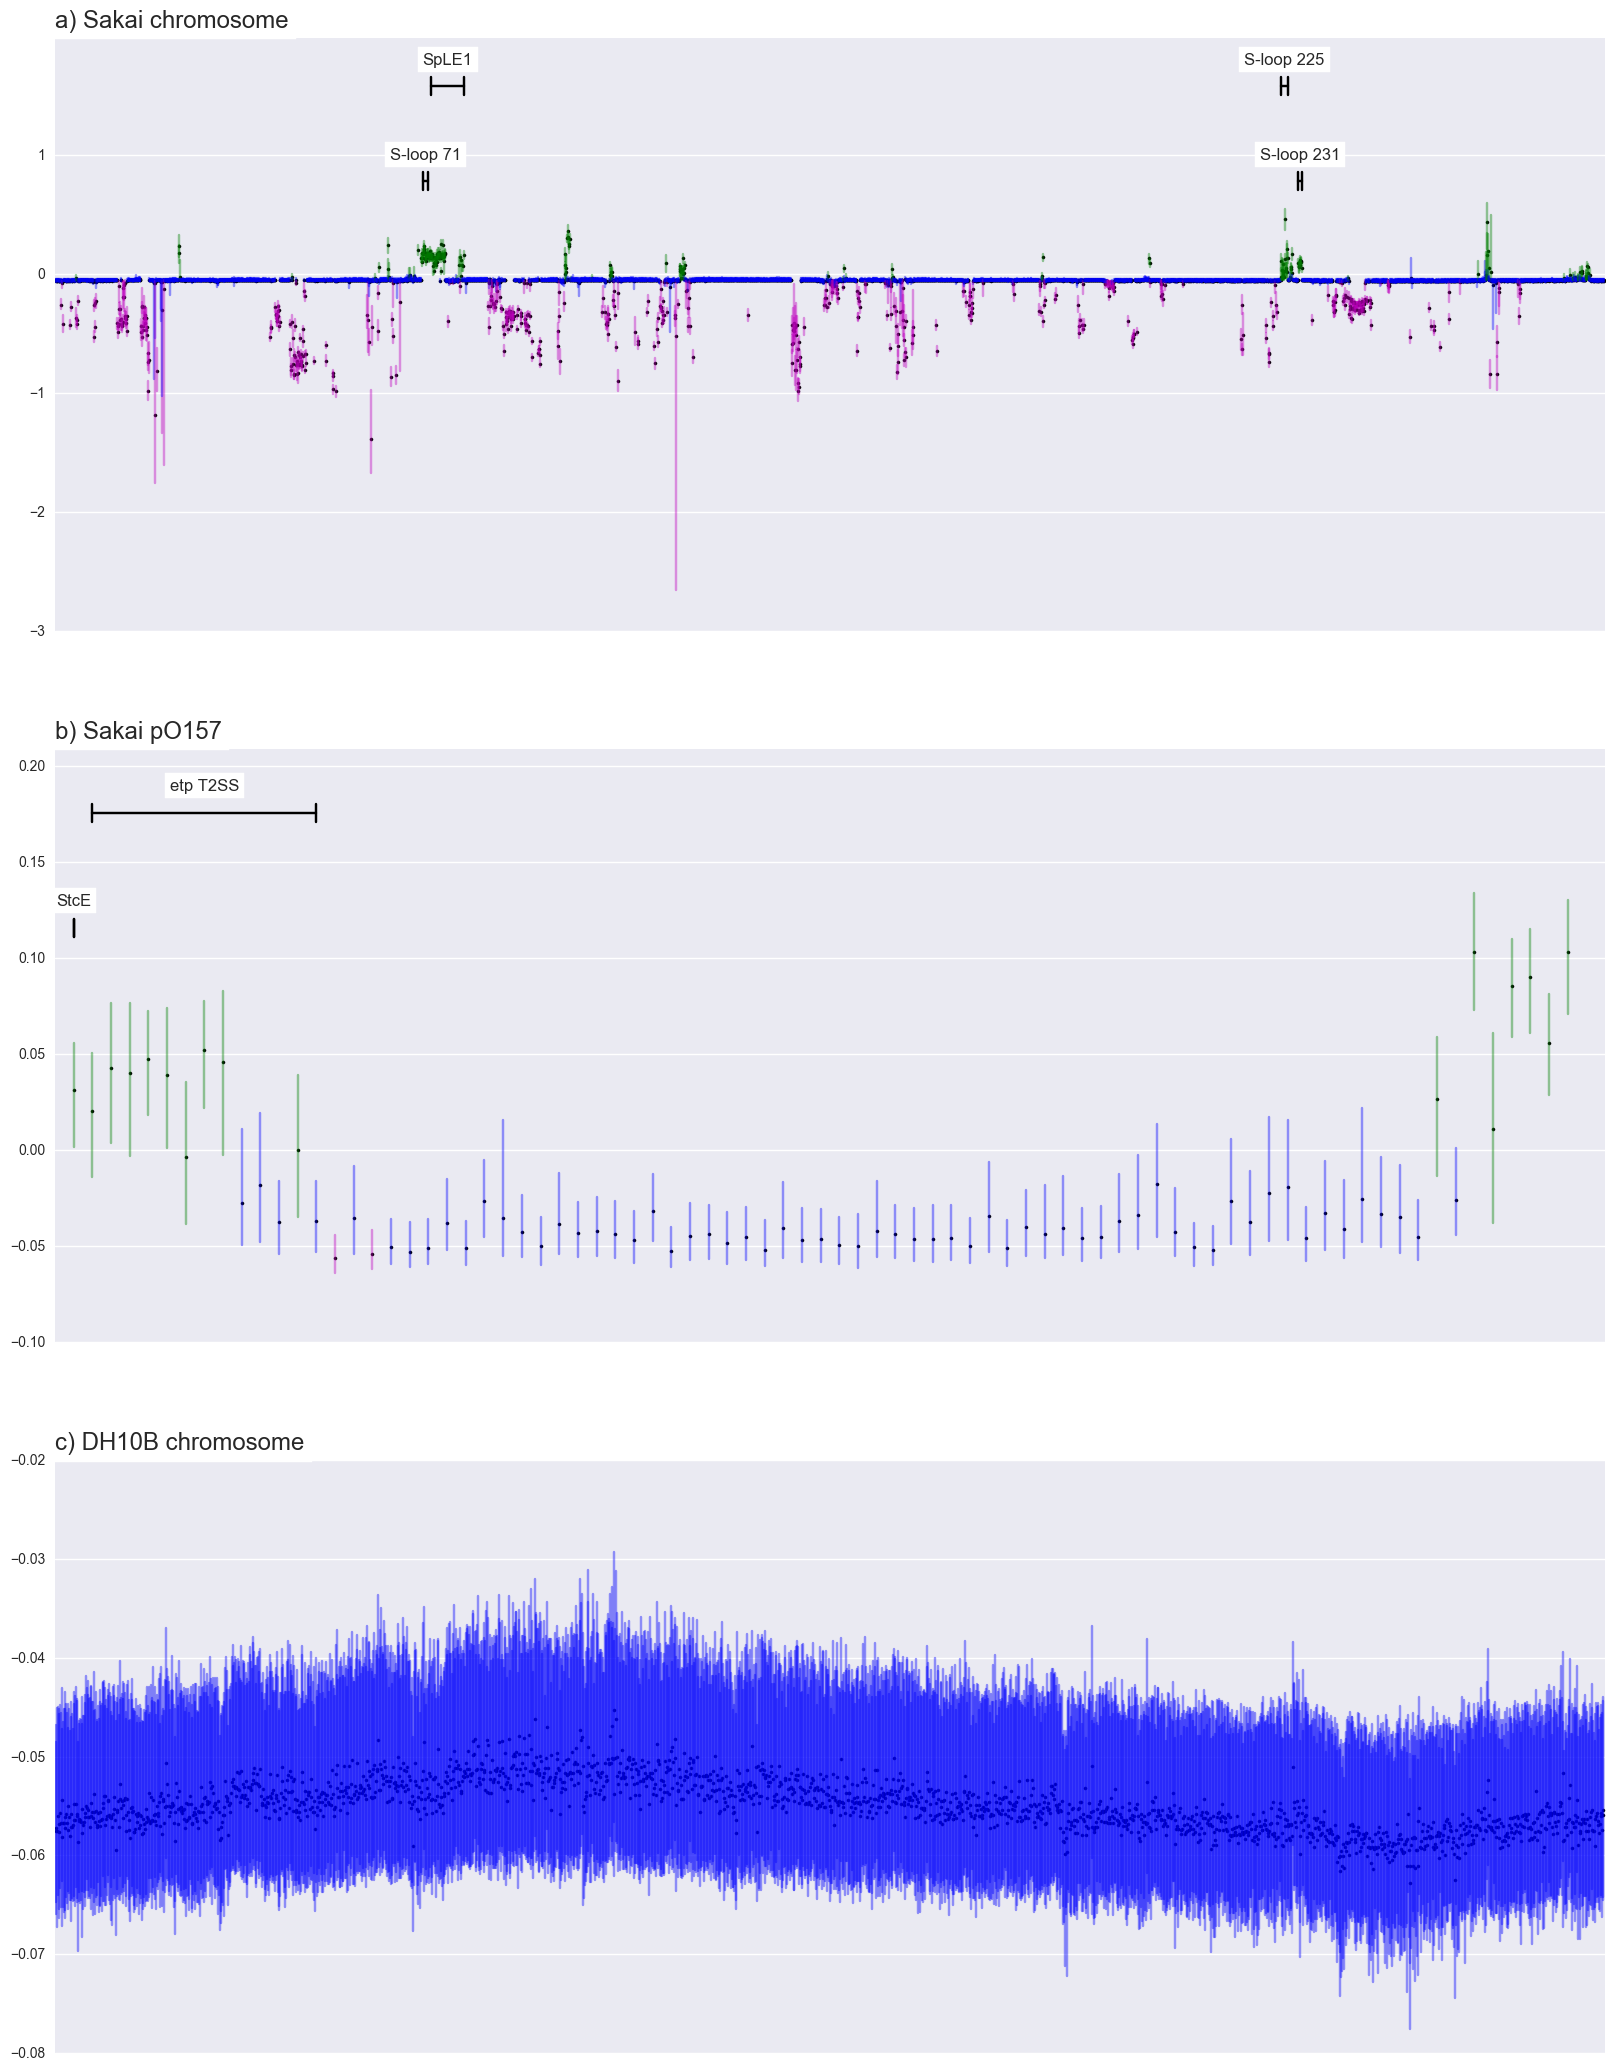

In [43]:
# Create figure with no title or xticks to hold the plotted axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 26))  

# Add subplot for each result

# 1) Sakai chromosome
regions = [('S-loop 71', 'ECs1276', 'ECs1288', 1),
           ('SpLE1', 'ECs1299', 'ECs1410', 1.8),
           ('S-loop 225', 'ECs4325', 'ECs4341', 1.8),
           ('S-loop 231', 'ECs4379', 'ECs4387', 1)]
annotations = {k:(tools.get_lt_index(v0, sakai_chromosome_annotated),
                  tools.get_lt_index(v1, sakai_chromosome_annotated), v2) for
               k, v0, v1, v2 in regions}
delta_thresh = np.median(sakai_chromosome_annotated['d_median'])
tools.plot_parameter(sakai_chromosome_annotated, ax1, 'd', delta_thresh, annotations=annotations,
                     label="a) Sakai chromosome")

# 2) pO157 plasmid
regions = [('StcE', 'pO157p01', 'pO157p01', 0.13),
           ('etp T2SS', 'pO157p02', 'pO157p14', 0.19)]
annotations = {k:(tools.get_lt_index(v0, sakai_pO157_annotated),
                  tools.get_lt_index(v1, sakai_pO157_annotated), v2) for
               k, v0, v1, v2 in regions}
delta_thresh = np.median(sakai_pO157_annotated['d_median'])
tools.plot_parameter(sakai_pO157_annotated, ax2, 'd', delta_thresh, annotations=annotations,
                     label="b) Sakai pO157")

# 3) DH10B chromosome
delta_thresh = np.median(dh10b_estimates['d_median'])
tools.plot_parameter(dh10b_estimates, ax3, 'd', delta_thresh, label="c) DH10B chromosome")

# Save figure as pdf
plt.savefig("figure_1.pdf");